# Bayesian option pricing
We look into particle filter aided Bayesian option pricing

## The Geometric Brownian motion
Assume that the risky asset can be modelled by the GBM
$$ dX_t = \mu(X_t)dt + \sigma(X_t)dW_t, $$
where $X_t$ is the price, $\mu$ the drift function, $\sigma$ the volatility function, and $dW_t$ a Weiner process.

We consider $\mu(X_t) := \mu X_t$ and $\sigma(X_t) := \sigma X_t$

## Numerical stepping
the GBM can be modeled directly to from t to T, but as an introduciton we use the Euler discretization,
$$ X_{j+1} = X_j + \mu X_j \Delta t + \sigma X_j \sqrt{\Delta t} Z_j, $$
where $Z_j \sim \mathcal{N}(0,1)$.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [76]:
def GBM_euler(X0, mu, sigma, T, N, M = 1):
    # initialize the price
    X = X0*np.ones([N,M])
    dt = T/(N+1)
    sqrtdt = np.sqrt(dt)
    
    # time-step
    for j in range(N):
        Z = np.random.randn(M)
        X[j,] = X[j-1,] + mu*X[j-1,]*dt + sigma*X[j-1,]*sqrtdt*Z
    return(X)

In [103]:
# constants
X0 = 14
mu = 0.1
sigma = 0.25
T = 0.5

N = 10
M = 10

In [80]:
X = GBM_euler(X0=X0, mu=mu, sigma=sigma, T=T, N=N, M=M)
t = np.linspace(0,T,N)

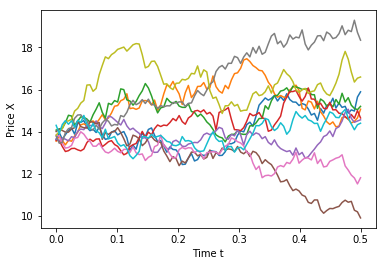

In [81]:
plt.plot(t,X)
plt.xlabel("Time t")
plt.ylabel("Price X")
plt.show()

## Analytical solution
As hinted above, there is a "true" solution for each step, naimly,
$$ X_t = X_0 \exp \bigg( (\mu - \frac{\sigma^2}{2})t - \sigma W_t \bigg). $$
This solution is derived through the use of Itô calculus.

In [120]:
def GBM(X0, mu, sigma, T, N, M = 1):
    dt = T/(N+1)
    step = np.exp((mu-sigma**2/2)*dt) * np.exp(sigma*np.random.normal(0,np.sqrt(dt),[N,M]))
    
    X = X0*step.cumprod(axis=0)

    return(X)

In [198]:
Y = GBM(X0, mu, sigma, T, N=1000, M=10)
Y[-1,]

array([ 8.50747593, 18.139668  , 16.11129828, 13.74467104, 15.19792873,
       17.14060973, 13.60238079, 15.31471783, 18.46854809, 12.29262687])

In [199]:
np.var(Y[-1,])

8.063662420038822

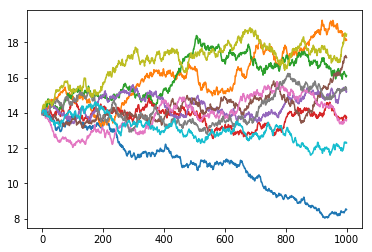

In [200]:
plt.plot(Y)
plt.show()

## Properties
From the analytical solution, we know some properties of the GBM. We know the expected value,
$$ \mathbb{E}(X_t) = X_0 e^{\mu t}, $$
and the variance,
$$ \mathbb{V}(X_t) = X_0^2 e^{2 \mu t} (e^{\sigma^2 t} - 1). $$

In [145]:
def gbm_exp(X0, mu, T):
    return(X0*np.exp(mu*T))

def gbm_var(X0, mu, sigma, T):
    return(X0**2 * np.exp(2*mu*T) * (np.exp(sigma**2 * T) - 1) )

In [146]:
gbm_exp(X0,mu,T)

14.717795349264337

In [147]:
gbm_var(X0,mu,sigma,T)

6.876050598492029

In [188]:
Y = GBM_euler(X0, mu, sigma, T, N, M=10000)
print("mean: ", np.mean(Y[-1,]))
print("var: ", np.var(Y[-1,]))

mean:  14.670827396066256
var:  6.113592044344385


# The particle filter
Given the observations $y$ we would like to estimate the probability $P(\mu, \sigma | y)$.

On the modeling, we can keep in mind that the log returns of $y$ are normally distributed,

$$ \log \frac{X_{j+1}}{X_j} =   (\mu - \frac{\sigma^2}{2})t - \sigma W_t, $$
with mean $(\mu - \frac{\sigma^2}{2})t$ and variance $\Delta t \sigma^2$.

In [215]:
Y

array([[13.92646855, 14.07973531, 13.95621315, ..., 13.96796037,
        14.14029564, 14.01215746],
       [13.9461733 , 14.17705822, 13.94483474, ..., 14.01862468,
        14.1781808 , 14.12307373],
       [14.05539058, 14.29703981, 14.04021723, ..., 13.93144699,
        14.3648215 , 14.13131595],
       ...,
       [ 8.55700218, 18.20209249, 16.13783733, ..., 15.38763773,
        18.3750919 , 12.34822727],
       [ 8.5214963 , 18.18158768, 16.0422283 , ..., 15.44936987,
        18.34576182, 12.29756409],
       [ 8.50747593, 18.139668  , 16.11129828, ..., 15.31471783,
        18.46854809, 12.29262687]])

(array([1., 0., 0., 2., 3., 0., 0., 1., 0., 1.]),
 array([0.00750458, 0.00924846, 0.01099234, 0.01273621, 0.01448009,
        0.01622396, 0.01796784, 0.01971171, 0.02145559, 0.02319946,
        0.02494334]),
 <a list of 10 Patch objects>)

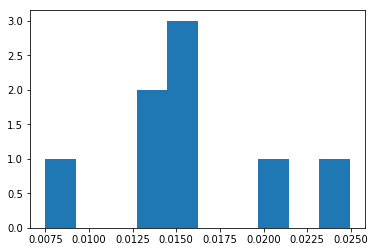

In [204]:
plt.hist(np.log(Y[2:N,1] / Y[1:N-1,2]))

In [ ]:
from scipy.stats import norm

# list of ideas
1) Propose $\theta := [\mu, \sigma]$ from the prior on $\theta$
2) In the loop, we aim to converge to a tight distribution on $\theta$, by
    * The cloud step forward 1 step,
    * how weight? distance between X and y? How is it done for stochastic volatility?

In [ ]:
def PF(y, X0, mu, sigma, T, N, M):
    dt = T/(N+1)
    
    
    # inital guess from prior
    X = np.random.normal(X0, 1, [M,1])
    # inital weights
    weights = np.ones([M,1])/M
    
    # start the procedure
    for i in range(N):
        # step the proposal [exactly 1 dt-step forward]
        Xhat = X * np.exp((mu-sigma**2/2)*dt) * np.exp(sigma*np.random.normal(0,np.sqrt(dt),[1,M]))
        
        # weights the proposals [see y_i, ]
        weights = norm()
        # resample?
        
        # store
        
        